In [6]:
from arango import ArangoClient
import os
import json

In [7]:
client = ArangoClient(hosts='http://localhost:8529')
db = client.db('Database_Material_Science', username='root', password='praddy')


## Load up the collections

In [8]:
entities = db.collection('entities')
publications = db.collection('publications')
edges = db.collection('publications_entities_edges')

In [9]:
from matplotlib import pyplot as plt
import pandas as pd

# 1. Basic analysis:

In [10]:
# Analysis year wise to see where we see a stark drop:

year_cap = 2024
QUERY_pub_by_year = f"""
                        LET yearCap = {year_cap}
                        FOR publication IN publications
                            FILTER publication.year <= yearCap
                            SORT publication.year ASC
                            RETURN {{ _key: publication._key, doi: publication.doi, year: publication.year }}
                        """

cursor = db.aql.execute(QUERY_pub_by_year)
results = list(cursor)

In [11]:
matkg_df = pd.DataFrame(results)
print(matkg_df.head())

       _key                           doi  year
0   4631163              10.1038/032345a0  1885
1  12105405  10.1016/0016-0032(89)90312-8  1889
2   3466929              10.1038/061485a0  1900
3   9250058              10.1038/061248a0  1900
4   4762066              10.1038/061456a0  1900


In [12]:
# Total publications:
print(matkg_df.shape[0])

3474972


### This  number (3474972) is same as shown in arangoDB that means we are fetching all entries

In [13]:
# Group publications by year:

df_yearly = matkg_df.groupby('year').size().reset_index(name='count')
print(df_yearly.head())


   year  count
0  1885      1
1  1889      1
2  1900    183
3  1901    164
4  1902    156


Text(0, 0.5, 'Count of Publications')

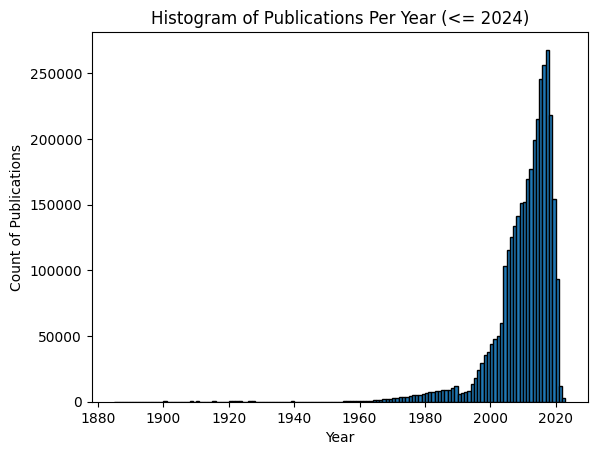

In [14]:
# Plot the raw histogram
plt.hist(df_yearly['year'], bins=range(df_yearly['year'].min(), df_yearly['year'].max() + 1), weights=df_yearly['count'], edgecolor='black')
plt.title(f'Histogram of Publications Per Year (<= {year_cap})')
plt.xlabel('Year')
plt.ylabel('Count of Publications')

# Let's take a look at the filtered json files to see how they are holding here:
## We will call it `Semantic-KG Dataset`

In [15]:
def process_json_df(data:json):
    rows = []

    for doi, details in data.items():
        year = details.get('year')
        abstract = details.get('abstract')
        paragraphs = details.get('paragraphs')

        if (len(abstract) == 0):
            abstract = ""

        rows.append({'doi': doi, 'year': year, 'abstract': abstract if len(abstract) > 0 else None, 'paragraphs': paragraphs if len(paragraphs) > 0 else None, 'count_para_lines': len(paragraphs), 'count_abstract_lines': len(abstract.split(' '))})

    df = pd.DataFrame(rows)
    return df

In [16]:
# path to the directory containing the filtered JSON files:
PATH_dir_json_files = r"D:\College\Research\Prof_jamshid\Training_SciBert\Dataset\SemanticScholar\downloaded\2023-12-27\s2orc\Share_With_Jamshid\matkg_json_files"

all_data = []

for folder in os.listdir(PATH_dir_json_files):
    
    PATH_curr_json = os.path.join(PATH_dir_json_files, folder)
    if (os.path.isfile(PATH_curr_json)):
        continue
    print('-'*15, '[INFO] FOUND FOLDER : ', folder, ' ', '-'*15)
    if (os.path.isdir(PATH_curr_json)):
        for json_file in os.listdir(PATH_curr_json):

            if (json_file.endswith('.json')):
                print(f"[INFO] Reading {json_file} --->")
                PATH_file = os.path.join(PATH_curr_json, json_file)

                with open(PATH_file) as f:
                    data = json.load(f)
                current_df = process_json_df(data)

                curr_json_data = {'json_filename' : json_file}
                curr_json_data['num_entries'] = current_df.shape[0]
                curr_json_data['count_abstracts'] = current_df['abstract'].count()
                curr_json_data['count_paras'] = current_df['paragraphs'].count()
                curr_json_data['count_abstracts_na'] = curr_json_data['num_entries'] - curr_json_data['count_abstracts']
                curr_json_data['count_paras_na'] = curr_json_data['num_entries'] - curr_json_data['count_paras']
                curr_json_data['count_lines'] = current_df['count_para_lines'].sum() + current_df['count_abstract_lines'].sum()
                curr_json_data['count_no_body'] = ((current_df['abstract'] == None) & (current_df['paragraphs'] == None)).sum()
                
                curr_json_data["df"] = current_df

                all_data.append(curr_json_data)
json_metadata_df = pd.DataFrame(all_data)

--------------- [INFO] FOUND FOLDER :  demo_ss_db_b1_b4   ---------------
[INFO] Reading 20231229_122646_00070_i8y36_00e81eb6-6d8a-4f3d-8e2a-478c1b1fe87b.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_0bd0ab3b-114a-441e-9fd6-15efef55a14b.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_0d5242b6-0f2c-4b78-9c9b-7f88d063c701.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_0fb3ab78-e3df-4dd2-86b9-1ad4a81dfa9e.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_20d1904d-c5d8-44d2-bde6-460fbde1b841.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_4a3b617c-2f7d-49cd-af46-68643dc54df5.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_4ffc4028-eee9-4993-8c55-597b5c15ec5d.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_6de21fc7-8e31-4435-98d1-f3c1345db844.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_7af665a0-394e-4583-87f9-1560dc7ea211.gz_filtered.json --->
[INFO] R

In [17]:
current_df.columns.to_list()

['doi',
 'year',
 'abstract',
 'paragraphs',
 'count_para_lines',
 'count_abstract_lines']

In [18]:
json_metadata_df

,json_filename,num_entries,count_abstracts,count_paras,count_abstracts_na,count_paras_na,count_lines,count_no_body,df
0,20231229_122646_00070_i8y36_00e81eb6-6d8a-4f3d...,8694,7515,8464,1179,230,2541927,0,doi year ...
1,20231229_122646_00070_i8y36_0bd0ab3b-114a-441e...,7626,6604,7410,1022,216,2195407,0,doi year \ ...
2,20231229_122646_00070_i8y36_0d5242b6-0f2c-4b78...,8178,7090,7962,1088,216,2361975,0,doi year \ 0 ...
3,20231229_122646_00070_i8y36_0fb3ab78-e3df-4dd2...,8164,7112,7927,1052,237,2347612,0,doi year \ ...
4,20231229_122646_00070_i8y36_20d1904d-c5d8-44d2...,8696,7611,8462,1085,234,2530542,0,doi year \ ...
5,20231229_122646_00070_i8y36_4a3b617c-2f7d-49cd...,8187,7103,7940,1084,247,2336582,0,doi year \ ...
6,20231229_122646_00070_i8y36_4ffc4028-eee9-4993...,7814,6755,7620,1059,194,2240098,0,doi year \ ...
7,20231229_122646_00070_i8y36_6de21fc7-8e31-4435...,7830,6797,7638,1033,192,2249654,0,doi year \ ...
8,20231229_122646_00070_i8y36_7af665a0-394e-4583...,8102,7013,7878,1089,224,2314941,0,doi year \ 0 ...
9,20231229_122646_00070_i8y36_9ab0f0c1-fa7e-4196...,7440,6448,7258,992,182,2132305,0,doi year ...


In [19]:
print('Total number of papers (filtered through MatKG2 from semantic Scholar): ', json_metadata_df['num_entries'].sum())
print("Total number of papers in MatKG2 ArangoDB Database: ", matkg_df.shape[0])
print(f"That mean a total of { matkg_df.shape[0] - json_metadata_df['num_entries'].sum()} papers were not present in SemanticScholar?")

Total number of papers (filtered through MatKG2 from semantic Scholar):  246152
Total number of papers in MatKG2 ArangoDB Database:  3474972
That mean a total of 3228820 papers were not present in SemanticScholar?


## There are a total of **~246k** research papers present in this filtered Dataset
## This number was **~3.47 Million** research papers in the original MatKG2 ArangoDB Dataset
## This mean, a total of **~3.2 Million** research papers are missing from this dataset

In [20]:
print("Total number of Abstracts in Semantic-KG Dataset: ", json_metadata_df['count_abstracts'].sum())
print("Total number of MISSING Abstracts in Semantic-KG Dataset: ", json_metadata_df['num_entries'].sum() - json_metadata_df['count_abstracts'].sum())

Total number of Abstracts in Semantic-KG Dataset:  213369
Total number of MISSING Abstracts in Semantic-KG Dataset:  32783


## There are a total of ~**213k** abstracts from all the papers in this dataset
## Meaning there are ~**32.7k** research papers that have no abstract.

In [21]:
print("Total number of Paragraphs in Semantic-KG Dataset: ", json_metadata_df['count_paras'].sum())
print("Total number of MISSING Paragraphs in Semantic-KG Dataset: ", json_metadata_df['count_paras'].sum() - json_metadata_df['count_abstracts'].sum())

Total number of Paragraphs in Semantic-KG Dataset:  239369
Total number of MISSING Paragraphs in Semantic-KG Dataset:  26000


## There are a total of ~**240k** Paragraphs from all the papers in this dataset
## Meaning there are **26k** research papers that have no Paragraphs.

In [22]:
print("Total number of Lines in Semantic-KG Dataset: ", json_metadata_df['count_lines'].sum())

Total number of Lines in Semantic-KG Dataset:  70642783


## There are a total of ~**70.64 Million** lines in this Datasett!!

In [23]:
print("Total number of papers with neither abstract nor paragraphs (meaning having no full body text): ", json_metadata_df['count_no_body'].sum())

Total number of papers with neither abstract nor paragraphs (meaning having no full body text):  0


## Intrestingly there are no papers that have complete text missing. 
* I'm pretty sure th reason is because I skipped paras and abstracts with none entries from SemanticSchollar when filtering this dataset.
* The following is a screen shot from the script `create_json_dataset.py` which is what created this filtered json dataset:

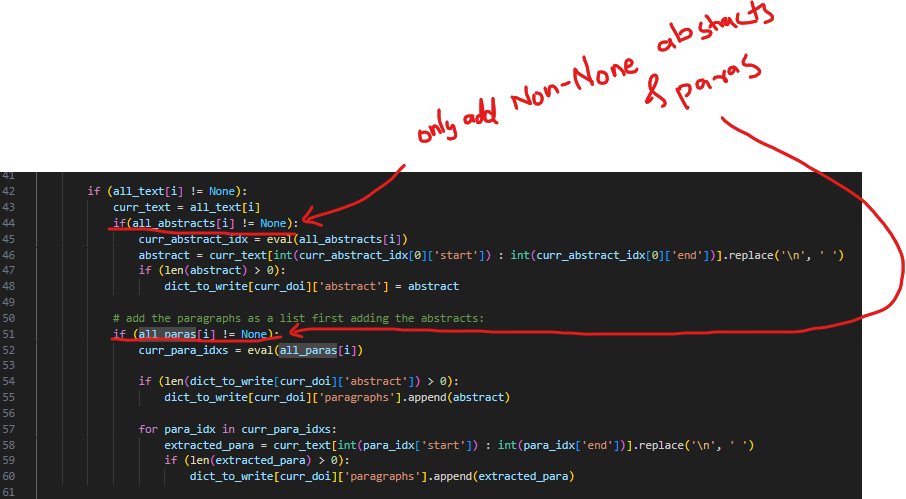


# But according to this code block, there should not be empty abstracts and paras too, then why are we getting those? (TODO)

## Let's load this up in a database

In [24]:
import pyodbc
from tqdm import tqdm

def get_mssql_odbc_driver():
    drivers = [driver for driver in pyodbc.drivers() if 'SQL Server' in driver]
    if drivers:
        return drivers[-1]
    else:
        raise Exception("No SQL Server ODBC Driver found. Make sure ODBC drivers are installed.")
    
def connect_to_mssql(server, database, username=None, password=None):
    driver = get_mssql_odbc_driver()
    connection_string = f"""
        DRIVER={{{driver}}};
        SERVER={server};
        DATABASE={database};
        UID={username};
        PWD={password};
        Trusted_Connection=no;
    """

    if username == None or password == None:
        connection_string = f"""
        DRIVER={{{driver}}};
        SERVER={server};
        DATABASE={database};
        Trusted_Connection=yes;
    """
    
    try:
        connection = pyodbc.connect(connection_string)
        print(f"Connected to MSSQL database '{database}' on server '{server}'")
        return connection
    except Exception as e:
        print(f"Error connecting to MSSQL database: {e}")
        return None

In [25]:
## Add your database credentials here:
server = 'DESKTOP-SC072N0\MSSQLSERVER01'
database = 'SemanticKG'
conn = connect_to_mssql(server, database)
cursor = conn.cursor() if conn is not None else exit(-1)

Connected to MSSQL database 'SemanticKG' on server 'DESKTOP-SC072N0\MSSQLSERVER01'


In [26]:
def insert_tblJsonFile(cursor:pyodbc.Connection.cursor, conn:pyodbc.Connection, entries:tuple):
    QUERY_insert_tblJsonFiles = """INSERT INTO tblJsonFiles
           ([JsonFile]
           ,[NumEntries]
           ,[NumAbs]
           ,[NumPara]
           ,[NumAbsLn]
           ,[NumParaLn]
           ,[NumLn])
     VALUES
           (?
           ,?
           ,?
           ,?
           ,?
           ,?
           ,?)"""
    VALUES_insert_tblJsonFiles = entries
    try:
        cursor.execute(QUERY_insert_tblJsonFiles, VALUES_insert_tblJsonFiles)
        conn.commit()
    except Exception as e:
        print("Error while writing to tblJsonFiles: ", e)


def insert_tblPaper(cursor:pyodbc.Connection.cursor, conn:pyodbc.Connection, json_df:pd.DataFrame):

    QUERY_insert_tblPaper = """INSERT INTO tblPaper
           ([doi]
           ,[Year]
           ,[JsonFile]
           ,[Abs]
           ,[Para]
           ,[NumParaLn]
           ,[NumAbsLn])
     VALUES
           (?
           ,?
           ,?
           ,?
           ,?
           ,?
           ,?)"""
    
    data = list(json_df[['doi', 'year', 'JsonFile', 'abstract', 'paragraphs', 'count_para_lines', 'count_abstract_lines']].itertuples(index=False, name=None))

    try:
        cursor.executemany(QUERY_insert_tblPaper, data)
        conn.commit()
    except Exception as e:
        print("Error while writing to tblPaper: ", e)

In [27]:
for json_entry in tqdm(all_data):
    current_df = json_entry['df']

    entries_json_file = (
        json_entry['json_filename'],            # JsonFile
        int(json_entry['num_entries']),              # NumEntries
        int(json_entry['count_abstracts']),          # NumAbs
        int(json_entry['count_paras']),              # NumPara 
        int(current_df['count_abstract_lines'].sum()),   # NumAbsLn
        int(current_df['count_para_lines'].sum()),       # NumParaLn
        int(json_entry['count_lines'])               # NumLn
    )

    print(f"[INFO] Writing {json_entry['json_filename']} ...")
    insert_tblJsonFile(cursor, conn, entries_json_file)

    current_df.insert(2, 'JsonFile', json_entry['json_filename'])
    insert_tblPaper(cursor, conn, current_df)

  0%|          | 0/30 [00:00<?, ?it/s]

[INFO] Writing 20231229_122646_00070_i8y36_00e81eb6-6d8a-4f3d-8e2a-478c1b1fe87b.gz_filtered.json ...
Error while writing to tblJsonFiles:  ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_tblJsonFiles'. Cannot insert duplicate key in object 'dbo.tblJsonFiles'. The duplicate key value is (20231229_122646_00070_i8y36_00e81eb6-6d8a-4f3d-8e2a-478c1b1fe87b.gz_filtered.json). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621)")
Error while writing to tblPaper:  ("A TVP's rows must all be the same size.", 'HY000')
[INFO] Writing 20231229_122646_00070_i8y36_0bd0ab3b-114a-441e-9fd6-15efef55a14b.gz_filtered.json ...
Error while writing to tblJsonFiles:  ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_tblJsonFiles'. Cannot insert duplicate key in object 'dbo.tblJsonFiles'. The duplicate key va

100%|██████████| 30/30 [00:00<00:00, 49.07it/s]

Error while writing to tblPaper:  ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_tblPaper'. Cannot insert duplicate key in object 'dbo.tblPaper'. The duplicate key value is (10.1039/c7sc01347g). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621)")
[INFO] Writing 20231229_122646_00070_i8y36_4a3b617c-2f7d-49cd-af46-68643dc54df5.gz_filtered.json ...
Error while writing to tblJsonFiles:  ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_tblJsonFiles'. Cannot insert duplicate key in object 'dbo.tblJsonFiles'. The duplicate key value is (20231229_122646_00070_i8y36_4a3b617c-2f7d-49cd-af46-68643dc54df5.gz_filtered.json). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621)")
Error while writing to tblPaper:  ("A TV

In [28]:
conn.close()